# Dataset analysis

In [1]:
import json
import pandas as pd
# file = open('/home/manuela/Downloads/refcocog-20230409T170358Z-001/refcocog/annotations/refs(umd).p', 'rb')
# obj = pickle.load(file)

path = '../data/raw/refcocog/'
obj = pd.read_pickle(path + 'annotations/refs(umd).p')
refs = json.loads(json.dumps(obj))

with open(path + 'annotations/instances.json', 'r') as file:
    inst = json.load(file)


/home/manuela/Universita/Magistrale/II_semestre/DL/Project/VGProject/notebooks


In [7]:
# images = pd.DataFrame(inst['images'])
# print(images.head())
print(refs[1])
print(inst['info'])
print(inst['images'][0])
print(inst['annotations'][0])
print(inst['categories'])
print(inst['licenses'])
splits = [refs[i]['split'] for i in range(len(refs))]
print(set(splits))
for i in inst:
    print(i)


{'image_id': 419645, 'split': 'test', 'sentences': [{'tokens': ['there', 'is', 'red', 'colored', 'truck', 'in', 'between', 'the', 'other', 'trucks'], 'raw': 'There is red colored truck in between the other trucks', 'sent_id': 10, 'sent': 'there is red colored truck in between the other trucks'}, {'tokens': ['a', 'shiny', 'red', 'vintage', 'pickup', 'truck'], 'raw': 'A shiny red vintage pickup truck', 'sent_id': 11, 'sent': 'a shiny red vintage pickup truck'}], 'file_name': 'COCO_train2014_000000419645_398406.jpg', 'category_id': 8, 'ann_id': 398406, 'sent_ids': [10, 11], 'ref_id': 1}
{'description': 'This is stable 1.0 version of the 2014 MS COCO dataset.', 'url': 'http://mscoco.org', 'version': '1.0', 'year': 2014, 'contributor': 'Microsoft COCO group', 'date_created': '2015-01-27 09:11:52.357475'}
{'license': 1, 'file_name': 'COCO_train2014_000000131074.jpg', 'coco_url': 'http://mscoco.org/images/131074', 'height': 428, 'width': 640, 'date_captured': '2013-11-21 01:03:06', 'flickr_ur

In [5]:
# Check number of images in images, annotations and references
images = set()
for image in inst['images']:
    images.add(image['id'])

img_ann = set()
for ann in inst['annotations']:
    img_ann.add(ann['image_id'])

for ann in inst['annotations']:
    img_ann.add(ann['image_id'])

# img_refs = set(refs['image_id'].unique())

print(len(images), len(img_ann),  len(inst['annotations']))


25799 25799 208960


COCO_train2014_000000060043.jpg
[{'tokens': ['a', 'woman', 'with', 'short', 'blonde', 'hair', 'wearing', 'a', 'blue', 'sweater', 'reaching', 'for', 'condiments'], 'raw': 'A woman with short blonde hair wearing a blue sweater reaching for condiments.', 'sent_id': 3682, 'sent': 'a woman with short blonde hair wearing a blue sweater reaching for condiments'}, {'tokens': ['woman', 'standing', 'wearing', 'grey', 'button', 'up', 'sweater'], 'raw': 'woman standing wearing grey button up sweater', 'sent_id': 3683, 'sent': 'woman standing wearing grey button up sweater'}]


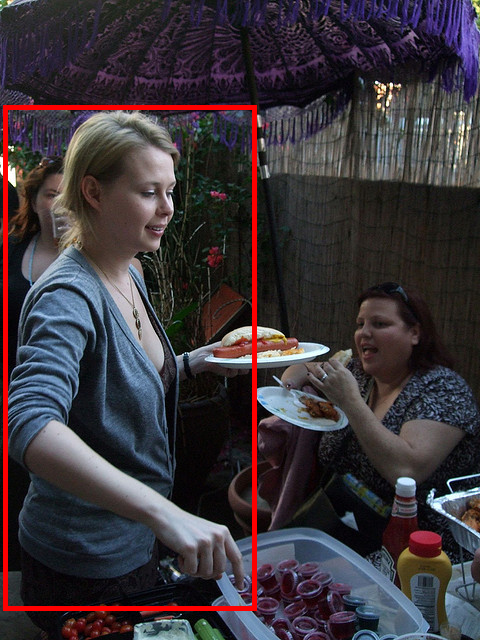

In [2]:
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision import transforms as t
from torchvision.ops import box_convert
ref = refs[157]

# print(ref['file_name']) remove the annotation id from name
bbox = [ann['bbox'] for ann in inst['annotations'] if ann['id'] == ref['ann_id']][0]
# print(bbox)
image_name = '_'.join(ref['file_name'].split('_')[0:-1]) + '.jpg'
print(image_name)
box = box_convert(torch.tensor([bbox]), in_fmt='xywh', out_fmt='xyxy')
# print(box.shape)
print(ref['sentences'])
image = read_image(path + 'images/'+image_name)
res = draw_bounding_boxes(image, boxes=box, colors='red', width=5)
t.ToPILImage()(res)


In [5]:
class Example():
    def __init__(self, id:str, split:str, sentences:list, image_id:str, file_name:str, category:dict, bbox:torch.Tensor) -> None:
        self.id = id
        self.split = split
        self.sentences = sentences
        self.image_id = image_id
        self.file_name = file_name
        self.category = category
        self.bbox = bbox
    
    def __str__(self):
        return f'''
[
    Id: {self.id},
    Split: {self.split},
    Sentences: {self.sentences},
    Image: {self.file_name},
    Category: {self.category['name']}
]'''

# example:Example = Example()
examples = []
for ref in refs[0:100]:
    sentences = []
    for sentence in ref['sentences']:
        sentences.append({
            'tokens': sentence['tokens'], 
            'sent': sentence['sent']
        })
    file_name = '_'.join(ref['file_name'].split('_')[0:-1]) + '.jpg'
    category = [{'category_id': cat['id'], 'name': cat['name']} for cat in inst['categories'] if cat['id'] == ref['category_id']][0]
    bbox = [ann['bbox'] for ann in inst['annotations'] if ann['id'] == ref['ann_id']][0]
    box = box_convert(torch.tensor([bbox]), in_fmt='xywh', out_fmt='xyxy')
    
    e = Example(ref['ref_id'], 
                    ref['split'], 
                    sentences,
                    ref['image_id'],
                    file_name,
                    category,
                    box)
    examples.append(e)



In [6]:
print(examples[0])



[
    Id: 0,
    Split: test,
    Sentences: [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'sent': 'the man in yellow coat'}, {'tokens': ['skiier', 'in', 'red', 'pants'], 'sent': 'skiier in red pants'}],
    Image: COCO_train2014_000000380440.jpg,
    Category: person
]


In [3]:
# Check images width and height to find the best one for resizing for batches

widths = []
heights = []
for image in inst['images']:
    widths.append(image['width'])
    heights.append(image['height'])

print(f'Max width: {max(widths)}, Min width: {min(widths)}, Avg width: {sum(widths)/len(widths)}')
print(f'Max height: {max(heights)}, Min height: {min(heights)}, Avg height: {sum(heights)/len(heights)}')

splits = [ref['split'] for ref in refs]
from collections import Counter
print(Counter(splits))


Max width: 640, Min width: 128, Avg width: 583.4593201286872
Max height: 640, Min height: 104, Avg height: 480.7301445792473
Counter({'train': 42226, 'test': 5023, 'val': 2573})


In [27]:
# Copyright 2017 Peter de Vocht
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import en_core_web_lg
from collections.abc import Iterable

# use spacy small model
nlp = en_core_web_lg.load()

# dependency markers for subjects
SUBJECTS = {"nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"}
# dependency markers for objects
OBJECTS = {"dobj", "dative", "attr", "oprd"}
# POS tags that will break adjoining items
BREAKER_POS = {"CCONJ", "VERB"}
# words that are negations
NEGATIONS = {"no", "not", "n't", "never", "none"}


# does dependency set contain any coordinating conjunctions?
def contains_conj(depSet):
    return "and" in depSet or "or" in depSet or "nor" in depSet or \
           "but" in depSet or "yet" in depSet or "so" in depSet or "for" in depSet


# get subs joined by conjunctions
def _get_subs_from_conjunctions(subs):
    more_subs = []
    for sub in subs:
        # rights is a generator
        rights = list(sub.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if contains_conj(rightDeps):
            more_subs.extend([tok for tok in rights if tok.dep_ in SUBJECTS or tok.pos_ == "NOUN"])
            if len(more_subs) > 0:
                more_subs.extend(_get_subs_from_conjunctions(more_subs))
    return more_subs


# get objects joined by conjunctions
def _get_objs_from_conjunctions(objs):
    more_objs = []
    for obj in objs:
        # rights is a generator
        rights = list(obj.rights)
        rightDeps = {tok.lower_ for tok in rights}
        if contains_conj(rightDeps):
            more_objs.extend([tok for tok in rights if tok.dep_ in OBJECTS or tok.pos_ == "NOUN"])
            if len(more_objs) > 0:
                more_objs.extend(_get_objs_from_conjunctions(more_objs))
    return more_objs


# find sub dependencies
def _find_subs(tok):
    head = tok.head
    while head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head:
        head = head.head
    if head.pos_ == "VERB":
        subs = [tok for tok in head.lefts if tok.dep_ == "SUB"]
        if len(subs) > 0:
            verb_negated = _is_negated(head)
            subs.extend(_get_subs_from_conjunctions(subs))
            return subs, verb_negated
        elif head.head != head:
            return _find_subs(head)
    elif head.pos_ == "NOUN":
        return [head], _is_negated(tok)
    return [], False


# is the tok set's left or right negated?
def _is_negated(tok):
    parts = list(tok.lefts) + list(tok.rights)
    for dep in parts:
        if dep.lower_ in NEGATIONS:
            return True
    return False


# get all the verbs on tokens with negation marker
def _find_svs(tokens):
    svs = []
    verbs = [tok for tok in tokens if tok.pos_ == "VERB"]
    for v in verbs:
        subs, verbNegated = _get_all_subs(v)
        if len(subs) > 0:
            for sub in subs:
                svs.append((sub.orth_, "!" + v.orth_ if verbNegated else v.orth_))
    return svs


# get grammatical objects for a given set of dependencies (including passive sentences)
def _get_objs_from_prepositions(deps, is_pas):
    objs = []
    for dep in deps:
        if dep.pos_ == "ADP" and (dep.dep_ == "prep" or (is_pas and dep.dep_ == "agent")):
            objs.extend([tok for tok in dep.rights if tok.dep_  in OBJECTS or
                         (tok.pos_ == "PRON" and tok.lower_ == "me") or
                         (is_pas and tok.dep_ == 'pobj')])
    return objs


# get objects from the dependencies using the attribute dependency
def _get_objs_from_attrs(deps, is_pas):
    for dep in deps:
        if dep.pos_ == "NOUN" and dep.dep_ == "attr":
            verbs = [tok for tok in dep.rights if tok.pos_ == "VERB"]
            if len(verbs) > 0:
                for v in verbs:
                    rights = list(v.rights)
                    objs = [tok for tok in rights if tok.dep_ in OBJECTS]
                    objs.extend(_get_objs_from_prepositions(rights, is_pas))
                    if len(objs) > 0:
                        return v, objs
    return None, None


# xcomp; open complement - verb has no suject
def _get_obj_from_xcomp(deps, is_pas):
    for dep in deps:
        if dep.pos_ == "VERB" and dep.dep_ == "xcomp":
            v = dep
            rights = list(v.rights)
            objs = [tok for tok in rights if tok.dep_ in OBJECTS]
            objs.extend(_get_objs_from_prepositions(rights, is_pas))
            if len(objs) > 0:
                return v, objs
    return None, None


# get all functional subjects adjacent to the verb passed in
def _get_all_subs(v):
    verb_negated = _is_negated(v)
    subs = [tok for tok in v.lefts if tok.dep_ in SUBJECTS and tok.pos_ != "DET"]
    if len(subs) > 0:
        subs.extend(_get_subs_from_conjunctions(subs))
    else:
        foundSubs, verb_negated = _find_subs(v)
        subs.extend(foundSubs)
    return subs, verb_negated


# find the main verb - or any aux verb if we can't find it
def _find_verbs(tokens):
    verbs = [tok for tok in tokens if _is_non_aux_verb(tok)]
    if len(verbs) == 0:
        verbs = [tok for tok in tokens if _is_verb(tok)]
    return verbs


# is the token a verb?  (excluding auxiliary verbs)
def _is_non_aux_verb(tok):
    return tok.pos_ == "VERB" and (tok.dep_ != "aux" and tok.dep_ != "auxpass")


# is the token a verb?  (excluding auxiliary verbs)
def _is_verb(tok):
    return tok.pos_ == "VERB" or tok.pos_ == "AUX"


# return the verb to the right of this verb in a CCONJ relationship if applicable
# returns a tuple, first part True|False and second part the modified verb if True
def _right_of_verb_is_conj_verb(v):
    # rights is a generator
    rights = list(v.rights)

    # VERB CCONJ VERB (e.g. he beat and hurt me)
    if len(rights) > 1 and rights[0].pos_ == 'CCONJ':
        for tok in rights[1:]:
            if _is_non_aux_verb(tok):
                return True, tok

    return False, v


# get all objects for an active/passive sentence
def _get_all_objs(v, is_pas):
    # rights is a generator
    rights = list(v.rights)

    objs = [tok for tok in rights if tok.dep_ in OBJECTS or (is_pas and tok.dep_ == 'pobj')]
    objs.extend(_get_objs_from_prepositions(rights, is_pas))

    #potentialNewVerb, potentialNewObjs = _get_objs_from_attrs(rights)
    #if potentialNewVerb is not None and potentialNewObjs is not None and len(potentialNewObjs) > 0:
    #    objs.extend(potentialNewObjs)
    #    v = potentialNewVerb

    potential_new_verb, potential_new_objs = _get_obj_from_xcomp(rights, is_pas)
    if potential_new_verb is not None and potential_new_objs is not None and len(potential_new_objs) > 0:
        objs.extend(potential_new_objs)
        v = potential_new_verb
    if len(objs) > 0:
        objs.extend(_get_objs_from_conjunctions(objs))
    return v, objs


# return true if the sentence is passive - at he moment a sentence is assumed passive if it has an auxpass verb
def _is_passive(tokens):
    for tok in tokens:
        if tok.dep_ == "auxpass":
            return True
    return False


# resolve a 'that' where/if appropriate
def _get_that_resolution(toks):
    for tok in toks:
        if 'that' in [t.orth_ for t in tok.lefts]:
            return tok.head
    return None


# simple stemmer using lemmas
def _get_lemma(word: str):
    tokens = nlp(word)
    if len(tokens) == 1:
        return tokens[0].lemma_
    return word


# print information for displaying all kinds of things of the parse tree
def printDeps(toks):
    for tok in toks:
        print(tok.orth_, tok.dep_, tok.pos_, tok.head.orth_, [t.orth_ for t in tok.lefts], [t.orth_ for t in tok.rights])


# expand an obj / subj np using its chunk
def expand(item, tokens, visited):
    if item.lower_ == 'that':
        temp_item = _get_that_resolution(tokens)
        if temp_item is not None:
            item = temp_item

    parts = []

    if hasattr(item, 'lefts'):
        for part in item.lefts:
            if part.pos_ in BREAKER_POS:
                break
            if not part.lower_ in NEGATIONS:
                parts.append(part)

    parts.append(item)

    if hasattr(item, 'rights'):
        for part in item.rights:
            if part.pos_ in BREAKER_POS:
                break
            if not part.lower_ in NEGATIONS:
                parts.append(part)

    if hasattr(parts[-1], 'rights'):
        for item2 in parts[-1].rights:
            if item2.pos_ == "DET" or item2.pos_ == "NOUN":
                if item2.i not in visited:
                    visited.add(item2.i)
                    parts.extend(expand(item2, tokens, visited))
            break

    return parts


# convert a list of tokens to a string
def to_str(tokens):
    if isinstance(tokens, Iterable):
        return ' '.join([item.text for item in tokens])
    else:
        return ''


# find verbs and their subjects / objects to create SVOs, detect passive/active sentences
def findSVOs(tokens):
    svos = []
    is_pas = _is_passive(tokens)
    verbs = _find_verbs(tokens)
    visited = set()  # recursion detection
    for v in verbs:
        subs, verbNegated = _get_all_subs(v)
        # hopefully there are subs, if not, don't examine this verb any longer
        if len(subs) > 0:
            isConjVerb, conjV = _right_of_verb_is_conj_verb(v)
            if isConjVerb:
                v2, objs = _get_all_objs(conjV, is_pas)
                for sub in subs:
                    for obj in objs:
                        objNegated = _is_negated(obj)
                        if is_pas:  # reverse object / subject for passive
                            svos.append((to_str(expand(obj, tokens, visited)),
                                         "!" + v.lemma_ if verbNegated or objNegated else v.lemma_, to_str(expand(sub, tokens, visited))))
                            svos.append((to_str(expand(obj, tokens, visited)),
                                         "!" + v2.lemma_ if verbNegated or objNegated else v2.lemma_, to_str(expand(sub, tokens, visited))))
                        else:
                            svos.append((to_str(expand(sub, tokens, visited)),
                                         "!" + v.lower_ if verbNegated or objNegated else v.lower_, to_str(expand(obj, tokens, visited))))
                            svos.append((to_str(expand(sub, tokens, visited)),
                                         "!" + v2.lower_ if verbNegated or objNegated else v2.lower_, to_str(expand(obj, tokens, visited))))
            else:
                v, objs = _get_all_objs(v, is_pas)
                for sub in subs:
                    if len(objs) > 0:
                        for obj in objs:
                            objNegated = _is_negated(obj)
                            if is_pas:  # reverse object / subject for passive
                                svos.append((to_str(expand(obj, tokens, visited)),
                                             "!" + v.lemma_ if verbNegated or objNegated else v.lemma_, to_str(expand(sub, tokens, visited))))
                            else:
                                svos.append((to_str(expand(sub, tokens, visited)),
                                             "!" + v.lower_ if verbNegated or objNegated else v.lower_, to_str(expand(obj, tokens, visited))))
                    else:
                        # no obj - just return the SV parts
                        svos.append((to_str(expand(sub, tokens, visited)),
                                     "!" + v.lower_ if verbNegated else v.lower_,))

    return svos


In [2]:
sents = []
for ref in refs[0:200]:
    sents.append(ref['sentences'][0]['sent'])
    # print(ref['sentences'][0]['sent'])

In [3]:
def get_subject_phrase(doc):
    for token in doc:
        # Mainly -ing verbs
        if("acl" in token.dep_):
            subtree = list(token.subtree)
            end = subtree[0].i
            sent = doc[0:end]
            if len(sent) > 1:
                return sent

    # subject which/that something
    for token in doc:
        if("relcl" in token.dep_):
            subtree = list(token.subtree)
            end = subtree[0].i
            sent = doc[0:end]
            if len(sent) > 1:
                return sent
            
    # Subjects
    for token in doc:
        if ("subj" in token.dep_):
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            sent = doc[start:end]
            if len(sent) > 1:
                return sent
    
    return doc

In [5]:
import spacy

nlp = spacy.load('en_core_web_lg')

for sentence in sents:
    doc = nlp(sentence)
    # subject_phrase = get_subject_phrase(doc)
    print(sentence)
    # print(subject_phrase)
    for chunk in doc.noun_chunks:
        print(chunk.text)
    print('----------------')


NameError: name 'sents' is not defined

In [8]:
# the white bedspread the man is laying on top of
# the toothbrush that is blue and white
# the vespa that is parked up on the sidewalk on this side of the rainy street
# the green ski board that the woman is holding
# giraffe whose head is in the barn

from spacy import displacy

doc = nlp("a lady pouring wine in the bigger glass")
displacy.render(doc, style='dep')

for token in doc:
    print(token.text, token.dep_, token.lemma_)

a det a
lady ROOT lady
pouring acl pour
wine dobj wine
in prep in
the det the
bigger amod big
glass pobj glass


COCO_train2014_000000440614.jpg
brown bread vegetable sandwich with tooth pick next to white bowl
torch.Size([3, 480, 640])


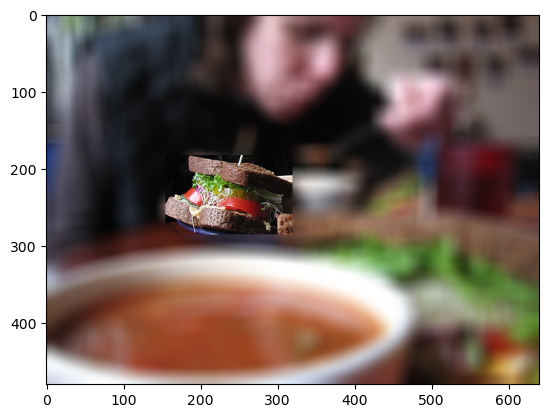

In [36]:
from networkx import draw
import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision import transforms as T
from torchvision.ops import box_convert
import matplotlib.pyplot as plt

ref = refs[51]

# print(ref['file_name']) remove the annotation id from name
bbox = [ann['bbox'] for ann in inst['annotations'] if ann['id'] == ref['ann_id']][0]
# print(bbox)
image_name = '_'.join(ref['file_name'].split('_')[0:-1]) + '.jpg'
print(image_name)
box = box_convert(torch.tensor([bbox]), in_fmt='xywh', out_fmt='xyxy')
# print(box.shape)
print(ref['sentences'][0]['sent'])
original = read_image(path + 'images/'+image_name)

# cv2.imshow('image', original)
blurred = T.GaussianBlur(25, 20)(original)
# blurred = cv2.GaussianBlur(original, (25,25), 0)
box = box.squeeze(0).numpy().astype(int)
blurred[:,box[1]:box[3], box[0]:box[2]] = original[:,box[1]:box[3], box[0]:box[2]]
print(blurred.shape)
plt.imshow(blurred.permute(1,2,0))
